In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib
import os
import pickle
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [33]:
#Load and Preprocess Data
df = pd.read_csv("dice_com-job_us_sample.csv")
df.dropna(subset=['jobdescription', 'skills', 'jobtitle'], inplace=True)
df['text'] = df['jobdescription'] + " " + df['skills']
df['text'] = df['text'].apply(lambda x: x.strip())

In [34]:
#Keep Top-100 Jobs
top_n = 100
top_titles = df['jobtitle'].value_counts().nlargest(top_n).index
df = df[df['jobtitle'].isin(top_titles)].reset_index(drop=True)

In [35]:
titles = df['jobtitle'].unique()

embedder = SentenceTransformer('all-mpnet-base-v2')
title_embed_path = "title_embeddings.pkl"

if os.path.exists(title_embed_path):
    embeddings = joblib.load(title_embed_path)
else:
    embeddings = embedder.encode(titles, show_progress_bar=True)
    joblib.dump(embeddings, title_embed_path)

kmeans = KMeans(n_clusters=25, random_state=42)
labels = kmeans.fit_predict(embeddings)

title_clusters = {title: f"Cluster {label}" for title,label in zip(titles,labels)}
df['job_title_grouped'] = df['jobtitle'].map(title_clusters)
cluster_to_label = df.groupby('job_title_grouped')['jobtitle'].agg(lambda x: x.value_counts().index[0]).to_dict()

In [36]:
cluster_to_label['Cluster 0'] = 'Software Engineer'
cluster_to_label['Cluster 4'] = 'Software Engineer'

In [37]:
df['job_title_grouped'] = df['job_title_grouped'].apply(lambda c: cluster_to_label.get(c, c))

In [38]:
# Encode job titles
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['job_title_grouped'])

In [39]:
#Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['text']).toarray()

In [40]:
#Embed Text
text = df['text'].values
text_embed_path = "text_embeddings.pkl"

if os.path.exists(text_embed_path):
    X_embed = joblib.load(text_embed_path)
else:
    X_embed = embedder.encode(text, show_progress_bar=True, batch_size=32)
    joblib.dump(X_embed, text_embed_path)
    
X_embed = embedder.encode(text)
y = df['label'].values

In [41]:
#Concatenate embedding and vector
X = np.hstack((X_tfidf, X_embed))

In [42]:
#Normalize Embeddings
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [43]:
# Train-test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [44]:
#Fix for class_weights computation
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [45]:
# Dataset class
class JobDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [46]:
# Wrapper class for sklearn compatibility
class SklearnJobClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=5000, num_classes=100, hidden1=512, hidden2=256, 
                 lr=1e-3, batch_size=64, epochs=5, class_weights=None):
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.class_weights = class_weights
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._build_model()

    def _build_model(self):
        self.model = nn.Sequential(
            nn.Linear(self.input_size, self.hidden1),
            nn.LayerNorm(self.hidden1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(self.hidden1, self.hidden2),
            nn.LayerNorm(self.hidden2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(self.hidden2, self.num_classes)
        ).to(self.device)
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device) if self.class_weights is not None else None)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self, loader):
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            output = self.model(X_batch)
            loss = self.loss_fn(output, y_batch)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            num_batches += 1
        avg_loss = epoch_loss/num_batches
        self.train_losses.append(avg_loss)
        return 

    def validate(self, loader):
        self.model.eval()
        total_loss = 0
        num_batches = 0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                output = self.model(X_batch)
                loss = self.loss_fn(output, y_batch)
                total_loss += loss
                num_batches += 1
        return total_loss/num_batches
    
    def fit(self, X, y, X_val=None, y_val=None):
        if X_val is None or y_val is None:
            sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
            for train_idx, val_idx in sss_val.split(X, y):
                X, X_val = X[train_idx], X[val_idx]
                y, y_val = y[train_idx], y[val_idx]

        self.train_val(X, y, X_val, y_val)
        return self

    def train_val(self, X_train, y_train, X_val, y_val):
        train_dataset = JobDataset(X_train, y_train)
        val_dataset = JobDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        self.best_val_loss = float('inf')
        self.patience = 1
        self.epochs_no_improve = 0
        self.early_stop = False  
        self._build_model()
        self.train_losses = []
        self.val_losses = []
        for _ in range(self.epochs):
            self.train(train_loader)
            val_loss = self.validate(val_loader)
            print("Validation Loss:",val_loss)
            self.val_losses.append(val_loss.item())

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), "job_model.pth")
                print("Validation Loss Improved")
                self.epochs_no_improve = 0
            else:
                self.epochs_no_improve += 1
                print("No improvement for", self.epochs_no_improve,"epoch(s)")

            if self.epochs_no_improve >= self.patience:
                print("Early Stopping Triggered")
                self.early_stop = True
                break
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            preds = torch.argmax(self.model(X_tensor), dim=1)
        return preds.cpu().numpy()

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [47]:
# Hyperparameter grid for GridSearchCV
param_grid = {
    'hidden1': [128, 256, 512, 1024],
    'hidden2': [64, 128, 256, 512],
    'lr': [1e-4, 1e-3, 1e-2],
    'batch_size': [32, 64, 128],
    'epochs': [3, 4, 5]
}

In [48]:
# Create classifier instance
clf = SklearnJobClassifier(input_size=X.shape[1], 
                           num_classes=len(label_encoder.classes_), 
                           class_weights=class_weights)

In [49]:
# Perform Grid Search
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = GridSearchCV(clf, param_grid=param_grid, cv=skf, verbose=2)
search.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Validation Loss: tensor(2.7887, device='cuda:0')
Validation Loss Improved
Validation Loss: tensor(2.5535, device='cuda:0')
Validation Loss Improved
Validation Loss: tensor(2.3937, device='cuda:0')
Validation Loss Improved
[CV] END batch_size=32, epochs=3, hidden1=128, hidden2=64, lr=0.0001; total time=   0.6s
Validation Loss: tensor(2.7326, device='cuda:0')
Validation Loss Improved
Validation Loss: tensor(2.4737, device='cuda:0')
Validation Loss Improved
Validation Loss: tensor(2.3021, device='cuda:0')
Validation Loss Improved
[CV] END batch_size=32, epochs=3, hidden1=128, hidden2=64, lr=0.0001; total time=   0.5s
Validation Loss: tensor(2.7810, device='cuda:0')
Validation Loss Improved
Validation Loss: tensor(2.5654, device='cuda:0')
Validation Loss Improved
Validation Loss: tensor(2.4178, device='cuda:0')
Validation Loss Improved
[CV] END batch_size=32, epochs=3, hidden1=128, hidden2=64, lr=0.0001; total time=   0.5s
Val

,estimator,SklearnJobCla...um_classes=23)
,param_grid,"{'batch_size': [32, 64, ...], 'epochs': [3, 4, ...], 'hidden1': [128, 256, ...], 'hidden2': [64, 128, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input_size,1768


In [50]:
print("Best Parameters:", search.best_params_)
print("Best CV Score:", search.best_score_)

Best Parameters: {'batch_size': 32, 'epochs': 4, 'hidden1': 1024, 'hidden2': 512, 'lr': 0.001}
Best CV Score: 0.8268968715555823


In [51]:
# Evaluate on test set
final_model = search.best_estimator_
y_pred = final_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.8288590604026845


In [52]:
final_model.model.load_state_dict(torch.load("job_model.pth"))

C:\Users\tsabu\AppData\Local\Temp\ipykernel_19008\3762708543.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.model.load_state_dict(torch.load("job_model.pth"

<All keys matched successfully>

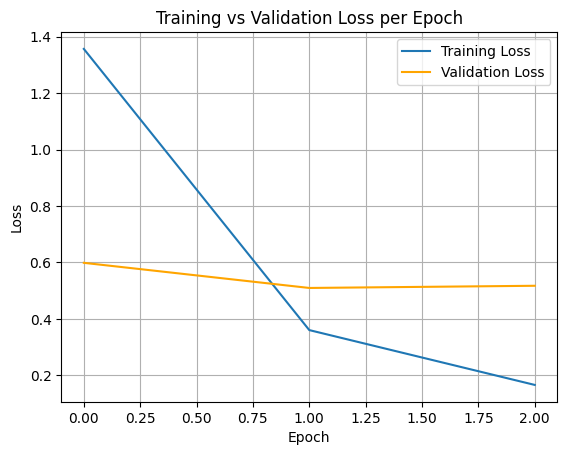

In [53]:
epochs = list(range(len(final_model.train_losses)))
plt.plot(epochs,final_model.train_losses,label='Training Loss')
plt.plot(epochs,final_model.val_losses,label='Validation Loss',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_job_title_with_similarity(resume_text):
    resume_text = resume_text.strip().lower()

    input_embed = embedder.encode([resume_text])
    input_tfidf = vectorizer.transform([resume_text]).toarray()
    input = np.hstack((input_tfidf, input_embed))
    input = scaler.transform(input)

    # Model prediction
    pred_label = final_model.predict(input)[0]

    # Cosine similarity to known title embeddings
    title_sim = cosine_similarity(input_embed, embeddings).flatten()
    best_sim_idx = np.argmax(title_sim)
    similarity_title = titles[best_sim_idx]

    # Only use similarity title if it's a valid label
    if similarity_title in label_encoder.classes_:
        similarity_label = label_encoder.transform([similarity_title])[0]

        # If model and similarity disagree, fallback to similarity
        if pred_label != similarity_label:
            pred_label = similarity_label

    decoded_label = label_encoder.inverse_transform([pred_label])[0]
    return decoded_label

In [55]:
#Sample Resumes
sample_resumes = {
    "Software Engineer": """
        Strong background in Python, Java, and C++.
        Skilled in developing scalable backend systems, building RESTful APIs, and deploying microservices
        using Docker and Kubernetes. Familiar with Git, Jenkins, and CI/CD pipelines.
    """,

    "Mobile App Developer": """
        Proficient in developing Android and iOS applications using Kotlin, Java, and Swift.
        Experience with Flutter and React Native for cross-platform development.
        Worked on integrating Firebase, location services, and payment gateways.
    """,

    "Frontend Developer": """
        Expert in HTML, CSS, JavaScript, and React.js.
        Experience in building responsive web interfaces, integrating APIs, and optimizing performance
        for SEO and accessibility.
    """,

    "Data Scientist": """
        Skilled in Python, R, and SQL. Hands-on experience with machine learning models
        using scikit-learn, TensorFlow, and pandas. Experienced in data preprocessing, feature engineering,
        and model evaluation. Familiar with Jupyter, Tableau, and Power BI.
    """,

    "Data Analyst": """
        Strong skills in Excel, SQL, Power BI, and Tableau.
        Experienced in data cleaning, ETL pipelines, and creating interactive dashboards to drive business insights.
    """,

    "Cloud Engineer": """
        Experienced in deploying and managing infrastructure on AWS and Azure.
        Skilled in EC2, S3, Lambda, CloudFormation, and Terraform. Familiar with containerization
        using Docker and orchestration with Kubernetes.
    """,

    "QA Engineer": """
        Experience in manual and automated testing using Selenium, JUnit, and Postman.
        Proficient in writing test cases, bug tracking, and using CI/CD tools like Jenkins.
    """,

    "Cybersecurity Analyst": """
        Experience in threat detection, SIEM tools, vulnerability scanning,
        and network security. Knowledge of firewalls, IDS/IPS, and risk assessment frameworks.
        Familiar with Kali Linux, Wireshark, and Metasploit.
    """,

    "Machine Learning Engineer": """
        Experienced in deep learning, NLP, and computer vision.
        Proficient in Python, PyTorch, TensorFlow, and OpenCV. Built and deployed models
        for real-time prediction and anomaly detection.
    """,

    "DevOps Engineer": """
        Experience in CI/CD, automation, and monitoring.
        Proficient in Jenkins, Ansible, Docker, and Kubernetes. Strong knowledge of GitOps,
        system administration, and scripting with Bash and Python.
    """
}

for title, resume in sample_resumes.items():
    predicted = predict_job_title_with_similarity(resume)
    print(f"Resume for: {title}\nPredicted Title: {predicted}\n")

Resume for: Software Engineer
Predicted Title: DevOps Engineer

Resume for: Mobile App Developer
Predicted Title: Android Developer

Resume for: Frontend Developer
Predicted Title: UI Developer

Resume for: Data Scientist
Predicted Title: Data Analyst

Resume for: Data Analyst
Predicted Title: Data Analyst

Resume for: Cloud Engineer
Predicted Title: DevOps Engineer

Resume for: QA Engineer
Predicted Title: QA Engineer

Resume for: Cybersecurity Analyst
Predicted Title: Security Engineer

Resume for: Machine Learning Engineer
Predicted Title: Data Analyst

Resume for: DevOps Engineer
Predicted Title: DevOps Engineer



In [56]:
decoded_true = label_encoder.inverse_transform(y_test)
decoded_pred = label_encoder.inverse_transform(y_pred)

true_title = decoded_true
pred_title = decoded_pred

print(classification_report(true_title,pred_title))

                                             precision    recall  f1-score   support

                             .Net Developer       0.79      0.79      0.79        28
                          Android Developer       0.80      1.00      0.89        16
                           Business Analyst       0.97      0.93      0.95        41
                               Data Analyst       0.68      0.81      0.74        21
                             Data Architect       0.90      0.82      0.86        11
                            Desktop Support       0.75      1.00      0.86         9
                            DevOps Engineer       0.78      0.80      0.79        40
                        Front End Developer       0.67      0.73      0.70        30
                           Hadoop Developer       0.75      1.00      0.86         3
                             Java Developer       0.89      0.87      0.88        62
                           Network Engineer       0.93      0.88

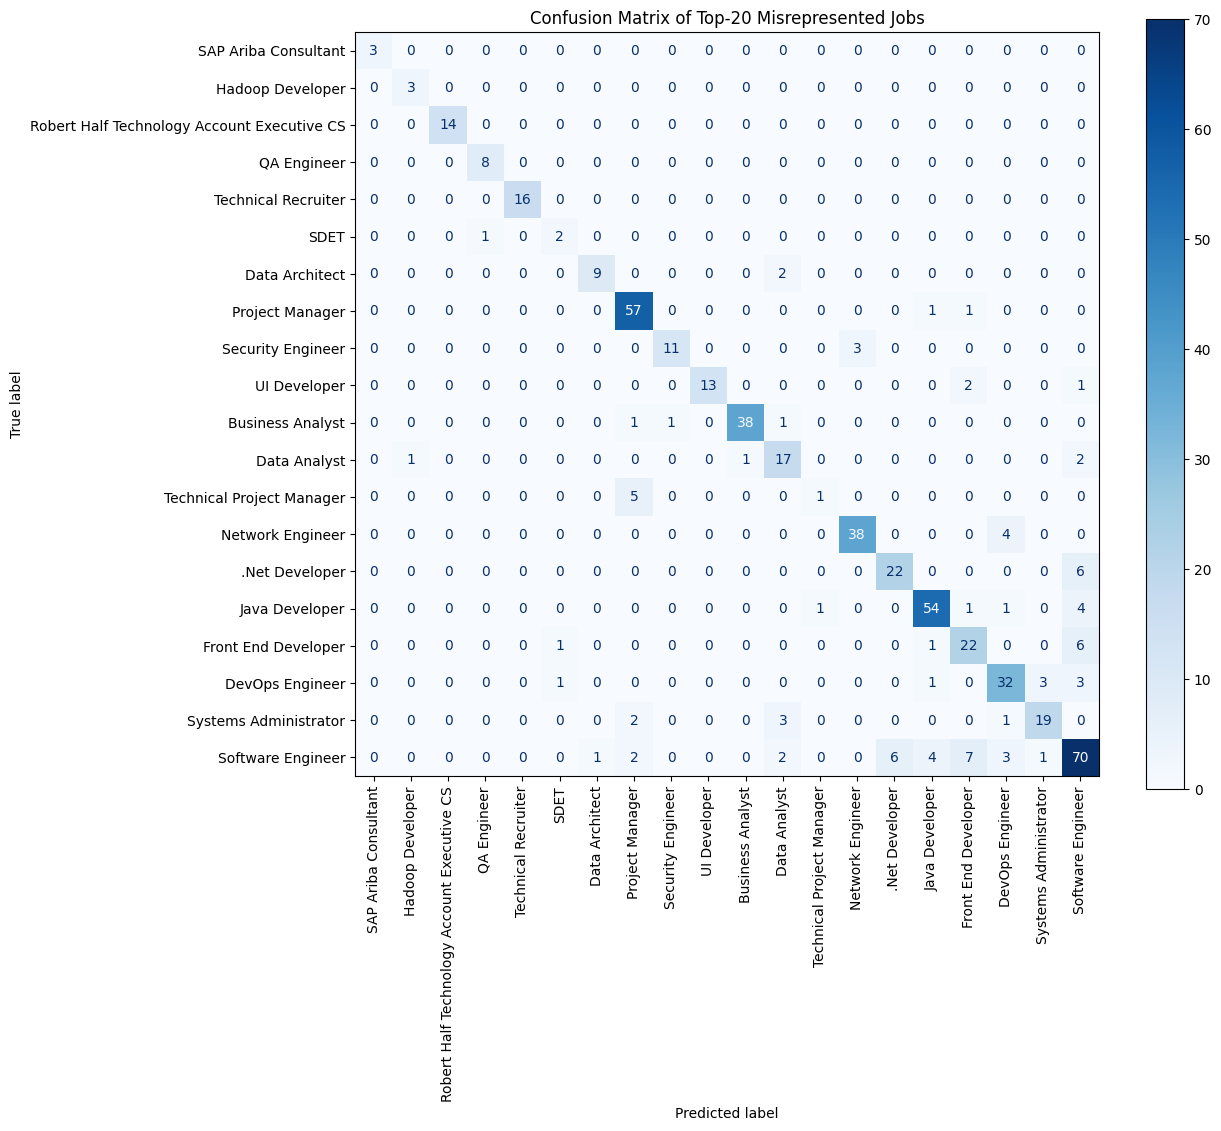

In [57]:
labels = np.arange(len(label_encoder.classes_))
cm_full = confusion_matrix(y_test, y_pred, labels=labels)

errors_per_class = np.sum(cm_full, axis=1) - np.diag(cm_full)
top_n = 20
top_indices = np.argsort(errors_per_class)[-top_n:]

cm_top = cm_full[np.ix_(top_indices, top_indices)]
display_labels_top = label_encoder.inverse_transform(top_indices)
#display_labels_top = [cluster_to_label[cluster] for cluster in inverse_cluster]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=display_labels_top)
fig = disp.plot(xticks_rotation=90, cmap="Blues").figure_
fig.set_size_inches(12, 10)
fig.set_facecolor('white')
plt.title("Confusion Matrix of Top-20 Misrepresented Jobs")
plt.show()

In [58]:
X.shape[1]  

1768

In [59]:
with open("label_encoder.pkl","wb") as f:
    pickle.dump(label_encoder,f)

with open("cluster_to_label.pkl","wb") as f:
    pickle.dump(cluster_to_label,f)

with open("scaler.pkl","wb") as f:
    pickle.dump(scaler,f)

with open("vectorizer.pkl","wb") as f:
    pickle.dump(vectorizer,f)